In [ ]:
import os
import random
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import pydicom
import re
import torch
from torch.utils.data import Dataset as dataset
from PIL import Image
from torchvision import datasets, transforms, models

In [ ]:

train_file = open("unet_train.txt")
valid_file = open("val.txt")
test_file = open("test.txt")


train_list = train_file.read().splitlines()
valid_list = valid_file.read().splitlines()
test_list = test_file.read().splitlines()


train_labels = sorted(["/home/ata/Desktop/Pancreas-CT/TCIA_pancreas_labels-02-05-2017/" + label for label in train_list])
valid_labels = sorted(["/home/ata/Desktop/Pancreas-CT/TCIA_pancreas_labels-02-05-2017/" + label for label in valid_list])
test_labels = sorted(["/home/ata/Desktop/Pancreas-CT/TCIA_pancreas_labels-02-05-2017/" + label for label in test_list])

def file_finder(dir_list):

    final_dirs = []
    main_dir = "/home/ata/Desktop/Pancreas-CT/Pancreas-CT/PANCREAS_"

    for dir in dir_list:
        final_dirs.append(main_dir +dir.split(".")[0])
    return final_dirs

def image_finder(image_dirs):
    image_paths =[]
    for path, subdirs, files in os.walk(image_dirs):
        for name in files:
            if(".dcm" in name ):
                image_paths.append(os.path.join(path,name))
    return image_paths

def full_path(dir):
    full_path = []

    temp_list = file_finder(dir)

    for folder in temp_list:
        full_path.append(sorted(image_finder(folder)))
    
    return full_path

train_images = full_path(sorted(train_list))
valid_images =  full_path(sorted(valid_list))
test_images =full_path(sorted(test_list))

train_images =  [item for sublist in train_images for item in sublist]
valid_images =  [item for sublist in valid_images for item in sublist]
test_images =  [item for sublist in test_images for item in sublist]

In [ ]:
nifti_img = pydicom.dcmread("/home/ata/Desktop/Pancreas-CT/Pancreas-CT/PANCREAS_0001/11-24-2015-PANCREAS0001-Pancreas-18957/Pancreas-99667/1-094.dcm")
bak = nifti_img.pixel_array


In [ ]:
"""def nifti_to_numpy_labels(labels,mod): # nifti to numpy conversion, run only once
    for i,label in enumerate(labels):
        nifti_img = nib.load(label[:62]+"label"+label[62:73])
       
        for j in range(nifti_img.dataobj.shape[2]):

            if(mod == "train"):
                
                np.save("npy/labels/train/train_"+str(i)+"_"+str(j),np.array(nifti_img.dataobj[:,:,j]))
        
            elif(mod == "valid"):
                
                np.save("npy/labels/valid/valid_"+str(i)+"_"+str(j),np.array(nifti_img.dataobj[:,:,j]))
                
            elif(mod == "test"):

                np.save("npy/labels/test/test_"+str(i)+"_"+str(j),np.array(nifti_img.dataobj[:,:,j]))


def nifti_to_numpy_images(images_dir,mod):# mod : train,valid,test

    for i,image_to_read in enumerate(images_dir):

        img = pydicom.dcmread(image_to_read)
        np.save(f"npy/images/{mod}/{mod}_pancreas_"+str(i),img.pixel_array)

        
nifti_to_numpy_labels(train_labels,"train")
nifti_to_numpy_labels(valid_labels,"valid")
nifti_to_numpy_labels(test_labels,"test")

nifti_to_numpy_images(train_images,"train")
nifti_to_numpy_images(valid_images,"valid")
nifti_to_numpy_images(test_images,"test") """

In [ ]:

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]



In [ ]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

deneme =  np.load("/home/ata/Desktop/Pancreas-CT/npy/images/valid/valid_pancreas_140.npy")
a=Image.fromarray(deneme)

transform = transforms.Compose([transforms.Resize(255),
                                transforms.RandomPerspective(),
                                transforms.ToTensor()])
img=transform(a)
type(a)


In [19]:
images_dir = "/home/ata/Desktop/Pancreas-CT/npy/images/"
label_dir = "//home/ata/Desktop/Pancreas-CT/npy/labels/"
mode = "train"
input_dir = images_dir + mode
input_img_paths = os.listdir(input_dir)
input_img_paths.sort(key=natural_keys)
for i in range(len(input_img_paths)):
    input_img_paths[i] = os.path.join(images_dir,input_img_paths[i])

input_img_paths[100] 

'/home/ata/Desktop/Pancreas-CT/npy/images/train_pancreas_100.npy'

(512, 512)


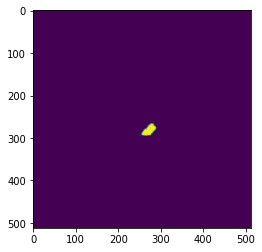

In [50]:
class DataReader(torch.utils.data.Dataset):
	def __init__(self, mode,transforms):
		super(DataReader, self).__init__()

		self.input_img_paths = []
		self.mask_paths = []
		self.mode = mode
		self.transforms =transforms

		images_dir = "/home/ata/Desktop/Pancreas-CT/npy/images/"
		label_dir = "//home/ata/Desktop/Pancreas-CT/npy/labels/"

		input_dir = images_dir + mode
		self.input_img_paths = os.listdir(input_dir)
		self.input_img_paths.sort(key=natural_keys)
		for i in range(len(self.input_img_paths)):
			self.input_img_paths[i] = os.path.join(input_dir,self.input_img_paths[i])


		label_dir = label_dir + mode
		self.mask_paths = os.listdir(label_dir)
		self.mask_paths.sort(key=natural_keys)
		for i in range(len(self.mask_paths)):
			self.mask_paths[i] = os.path.join(label_dir,self.mask_paths[i])		


	def __getitem__(self, index):
		
		img = np.load(self.input_img_paths[index])
		mask = np.load(self.mask_paths[index])

		img = Image.fromarray(img)
		mask = Image.fromarray(mask)


		data = {}
		data['image'] = img
		data['mask'] = mask

		if self.transforms:
			data = self.transforms(data)

		return data	

	def __len__(self):
		return len(self.input_img_paths)

class Resize(object):
	def __call__(self, data):
		
		x = random.uniform(0.98, 1.1)
		img,mask = data["image"],data["mask"]
		
		w, h = img.size
		new_w = int(x*w)
		new_h = int(x*h)

		resize = transforms.Resize(size=(new_h, new_w))
		resized_image = resize(img)
		resized_mask = resize(mask)

		return{"image": resized_image, "mask": resized_mask }

class RandomCrop(object):
	def __call__(self,data):

		img,mask = data["image"],data["mask"]
		i, j, he, wi = transforms.RandomCrop.get_params(img, output_size=(512, 512))

		crop_image = transforms.functional.crop(img, i, j, he, wi)
		crop_mask = transforms.functional.crop(mask, i, j, he, wi)
		
		return{"image": crop_image, "mask": crop_mask }

class RandomPerspective(object):
	def __call__(self,data):

		img,mask = data["image"],data["mask"]
		sp, ep = transforms.RandomPerspective.get_params(width = 512, height = 512, distortion_scale = 0.5)

		new_image = transforms.functional.perspective(img, sp, ep)
		new_mask = transforms.functional.perspective(mask, sp, ep)				

		return{"image": new_image, "mask": new_mask }

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        image, mask = data['image'], data['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((0, 1))
        return {'image': transforms.ToTensor()(image),
                'mask': transforms.ToTensor()(mask)}





composed = transforms.Compose([Resize(),
                               RandomCrop(),
							   RandomPerspective(),
							   ToTensor()])


img =  np.load("/home/ata/Desktop/Pancreas-CT/npy/images/valid/valid_pancreas_140.npy")
mask =  np.load("/home/ata/Desktop/Pancreas-CT/npy/labels/valid/valid_0_140.npy")

img=Image.fromarray(img)
mask=Image.fromarray(mask)
print(img.size)
data = {"image":img, "mask":mask}

final=composed(data)

final_img = final["mask"]
plt.imshow(final_img[0])

In [53]:
train_dataset = DataReader("train",transforms=transforms.Compose([RandomCrop(),
                               Resize(),
							   RandomPerspective(),
							   ToTensor()]))
for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['mask'].size())

    if i == 3:
        break

0 torch.Size([1, 522, 522]) torch.Size([1, 522, 522])
1 torch.Size([1, 521, 521]) torch.Size([1, 521, 521])
2 torch.Size([1, 562, 562]) torch.Size([1, 562, 562])
3 torch.Size([1, 546, 546]) torch.Size([1, 546, 546])


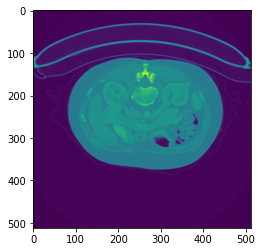

In [40]:
k =np.load("/home/ata/Desktop/Pancreas-CT/npy/images/train/train_pancreas_0.npy")
plt.imshow()

In [ ]:
class Dataset(dataset):
    def __init__(self, main_dir, seg_dir):
        
    for path, subdirs, files in os.walk(image_path):
        for name in files:
            if(".dcm" in name ):
                self.image_list.append(name)

    
self.seg_list =seg_dir

        

    def __getitem__(self, index):
        """
        :param index:
        :return: torch.Size([B, 1, 48, 256, 256]) torch.Size([B, 48, 256, 256])
        """

        image_path = self.image_list[index]
        seg_path = self.seg_list[index]

        # 将image和金标准读入到内存中
        image =  pydicom.dcmread(image_path)
        seg = sitk.ReadImage(seg_path, sitk.sitkUInt8)

        image_array = sitk.GetArrayFromImage(image)
        seg_array = sitk.GetArrayFromImage(seg)

        # 在slice平面内随机选取48张slice
        start_slice = random.randint(0, image_array.shape[0] - size)
        end_slice = start_slice + size - 1

        image_array = image_array[start_slice:end_slice + 1, :, :]
        seg_array = seg_array[start_slice:end_slice + 1, :, :]

        # 处理完毕，将array转换为tensor
        image_array = torch.FloatTensor(image_array).unsqueeze(0)
        seg_array = torch.FloatTensor(seg_array)

        return image_array, seg_array

    def __len__(self):

        return len(self.image_list)
